# Libraries

In [ ]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable

# Directories

In [2]:
wtd_csv_path = "/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv"
meteo_nc_path = "/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc"
wtd_stations_shp_path = "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp"
dtm_nc_path = "/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc"

# Dataset class

In [5]:
np.isnan(np.array([np.nan, 1,2]))

array([ True, False, False])

In [63]:

class ContinuousDataset(Dataset):
    """Weather and WTD Dataset for the continuous case model"""

    def __init__(self, dict_files, #meteo_nc_path, wtd_csv_path, wtd_stations_shp_path,
                 transform = None):
        """
        Args:
            dict_files (string): Path to the .nc file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        
        # Attributes init
        self.dict_files = dict_files
        self.timesteps = self.dict_files["timesteps"]

        # Meteorological data loading 
        self.loading_weather()
        
        # Digital Terrain Model data loading
        self.loading_dtm()
        
        # Water Table Depth data loading 
        self.loading_point_wtd()

        # Transform       
        self.transform = transform
        
    def loading_dtm(self):
        self.dtm_roi = rioxarray.open_rasterio(self.dict_files["dtm_nc"],
                                               engine='fiona')
        self.dtm_roi = self.dtm_roi.rio.write_crs("epsg:4326")
        
            
    def loading_weather(self):
        self.weather_xr = xarray.open_dataset(self.dict_files["weather_nc_path"])
        self.weather_xr = self.weather_xr.rio.write_crs("epsg:4326")
        
        # Compute coord matrix
        lat_matrix = np.vstack([self.weather_xr.lat.values for i in range(len(self.weather_xr.lon.values))]).transpose()
        lon_matrix = np.vstack([self.weather_xr.lon.values for i in range(len(self.weather_xr.lat.values))])
        self.weather_coords = np.stack([lat_matrix,lon_matrix], axis = -1)
        

    def loading_point_wtd(self):
        
        # Water Table Depth data loading
        self.wtd_df = pd.read_csv(self.dict_files["wtd_csv_path"], 
                                    dtype= {"sensor_id": "str"})
        self.wtd_df = self.wtd_df.astype({"date":'datetime64[ns]'})

        # Water Table Depth Sensors shapefile loading: 
        self.wtd_names = gpd.read_file(self.dict_files["wtd_shp"],
                                             engine='fiona')
        self.wtd_names = self.wtd_names.to_crs('epsg:4326')

        # Define attributes about dates and coordinates
        self.dates = self.wtd_df["date"].unique()
        self.sensor_id_list = self.wtd_df["sensor_id"].unique()
        
        
        ### Merge csv and shp into a joint spatio temporal representation
        sensor_coord_x_list = []
        sensor_coord_y_list = []

        # Retrieve coordinates from id codes
        for sensor in self.sensor_id_list:
            coord_x = self.wtd_names.loc[self.wtd_names["sensor_id"] == sensor].geometry.x.values[0]
            coord_y = self.wtd_names.loc[self.wtd_names["sensor_id"] == sensor].geometry.y.values[0]
            sensor_coord_x_list.append(coord_x)
            sensor_coord_y_list.append(coord_y)

        # Buil a dictionary of coordinates and id codes
        from_id_to_coord_x_dict = {self.sensor_id_list[i]: sensor_coord_x_list[i] for i in range(len(sensor_coord_x_list))}
        from_id_to_coord_y_dict = {self.sensor_id_list[i]: sensor_coord_y_list[i] for i in range(len(sensor_coord_y_list))}

        # Map id codes to coordinates for all rows in the original ds
        queries = list(self.wtd_df["sensor_id"].values)
        coordinates_x = itemgetter(*queries)(from_id_to_coord_x_dict)
        coordinates_y = itemgetter(*queries)(from_id_to_coord_y_dict)

        # insert new columns containing coordinates
        self.wtd_df["x"] = coordinates_x
        self.wtd_df["y"] = coordinates_y
        
        self.wtd_df = self.wtd_df.set_index(["date","y","x"])
        
        # Truncate dataset wrt `timestep`
        
        # Subset wtd data truncating the last `timestep` instances
        last_date = self.dates.max() - np.timedelta64(self.timesteps, 'D')
        self.input_dates = self.dates[self.dates <= last_date]
        
    def __len__(self):
        data = self.wtd_df.loc[pd.IndexSlice[self.wtd_df.index.get_level_values(0) <= self.input_dates.max(),
                                                       :,
                                                       :]]
        return len(data)
    
    def __getitem__(self, idx):
        
        if idx < 0:
            idx = self.__len__() + idx
        
        # Retrieve date and coords for idx instance
        start_date = self.wtd_df.iloc[idx, :].name[0]
        sample_lat = self.wtd_df.iloc[idx, :].name[1]
        sample_lon = self.wtd_df.iloc[idx, :].name[2]
        sample_dtm = self.dtm_roi.sel(x = sample_lon,
                                      y = sample_lat,
                                      method = "nearest").values  
        
        end_date = start_date + np.timedelta64(self.timesteps, "D")
        
        print("start date: ", str(start_date))
        print("end date: ", str(end_date))
        
        # Initial state WTD (t0) data
        wtd_t0 = self.wtd_df["wtd"].loc[self.wtd_df.index.get_level_values(0) == start_date]
        wtd_t0_values = wtd_t0.values
        wtd_t0_lat = wtd_t0.index.get_level_values(1).values
        wtd_t0_lon = wtd_t0.index.get_level_values(2).values
        wtd_t0_dtm = np.array([self.dtm_roi.sel(x = wtd_t0_lon[sensor],
                                                y = wtd_t0_lat[sensor],
                                                method = "nearest") for sensor in range(len(wtd_t0_lat))])
        
        wtd_t0_mask = np.isnan(wtd_t0_values)
        X = [wtd_t0_lat, wtd_t0_lon, wtd_t0_dtm, wtd_t0_values, wtd_t0_mask]
        
        # Retrieve wtd values from t0+1 to T for the idx instance sensor
        wtd_t1_T = self.wtd_df["wtd"].loc[(self.wtd_df.index.get_level_values(0) > start_date) &
                                          (self.wtd_df.index.get_level_values(0) <= end_date)  & 
                                          (self.wtd_df.index.get_level_values(1) == sample_lat)&
                                          (self.wtd_df.index.get_level_values(2) == sample_lon)]
        
        wtd_t1_T_values =  wtd_t1_T.values
        wtd_t1_T_mask =  np.isnan(wtd_t1_T_values)
                # For P > 1
                # # WTD from t1 to T(`timestep`)
                # wtd_t1_T = self.wtd_df["wtd"].loc[(self.wtd_df.index.get_level_values(0) > start_date) & (self.wtd_df.index.get_level_values(0) <= end_date)] 
                # wtd_t1_T = [wtd for _, wtd in wtd_t1_T.groupby(level=0)] # formatting shape (timestep, sensors)
                
                # # Retrieve wtd values from t0+1 to T
                # wtd_t1_T_values = [wtd_t1_T[i].values for i in range(len(wtd_t1_T))]
                # # Retrieve coordinates (lat, lon) of sensors from t0+1 to T
                # wtd_t1_T_lat = [wtd_t1_T[day].index.get_level_values(1).values for day in range(len(wtd_t1_T))]
                # wtd_t1_T_lon = [wtd_t1_T[day].index.get_level_values(2).values for day in range(len(wtd_t1_T))]
                # wtd_t1_T_dtm = [np.array([self.dtm_roi.sel(x = wtd_t0_lon[sensor],
                #                                y = wtd_t0_lat[sensor],
                #                                method = "nearest") for sensor in range(len(wtd_t1_T[day]))]) for day in range(len(wtd_t1_T))]
                
        Z = [sample_lat,
             sample_lon,
             sample_dtm]
        
        Y = [wtd_t1_T_values,
             wtd_t1_T_mask]
        
        # Retrieve weather data
        weather_video = self.weather_xr.sel(time = slice(start_date + np.timedelta64(1, "D"),
                                                    end_date)) #slice include extremes
        weather_video = weather_video.to_array().values
        W = [weather_video, self.weather_coords]
        
        if self.transform:
            sample = self.transform(sample)
        
        return [X, Z, W, Y]

In [64]:
dict_files = {
    "wtd_csv_path" : "/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv",
    "weather_nc_path" : "/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc",
    "wtd_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp",
    "piedmont_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp",
    "dtm_nc" : "/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc",
    "timesteps" : 90
}

ds = ContinuousDataset(dict_files)

In [65]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 314247


In [67]:
print(f"Item -1: {ds[-1]}")

start date:  2023-10-02 00:00:00
end date:  2023-12-31 00:00:00
Item -1: [[array([44.69885435, 44.56781696, 44.41862659, 44.86085945, 44.96300459,
       44.88944275, 44.77265463, 44.51817815, 45.05099958, 44.82984236,
       44.73118245, 44.50843288, 44.64595595, 44.92544405, 44.68881859,
       44.57011559, 44.88793304, 44.76677829, 45.09390248, 45.07815508,
       45.01630172, 44.86887529, 44.48904444, 44.68957671, 44.87791979,
       44.78736814, 44.95656112, 44.78702374, 45.00557706, 44.96544614,
       45.02453956]), array([7.64028934, 7.72640048, 7.53721525, 7.72379089, 7.67314212,
       7.49479721, 7.68793508, 7.53227261, 7.65555227, 7.3085028 ,
       7.33948118, 7.48981833, 7.65242128, 7.84773289, 7.84573366,
       7.57503319, 7.68684886, 7.5292754 , 7.5746718 , 7.71870821,
       7.53446284, 7.56489482, 7.64965102, 7.56770232, 7.41559925,
       7.38102768, 7.59870417, 7.73514017, 7.8948282 , 7.7706351 ,
       7.6636863 ]), array([[284.93298],
       [355.4048 ],
       [

In [ ]:
# FOR SHIFTING: 
#df['beyer_shifted'] = df.groupby(level=0)['beyer'].shift(1); df


# DEVI SHIFTAREE

In [14]:
ds_prova = Meteo_WTD_Continuous_Dataset(meteo_nc_path = meteo_nc_path,
                              wtd_csv_path = wtd_csv_path,
                                wtd_stations_shp_path = wtd_stations_shp_path)

In [16]:
ds_prova.wtd_ds

,date,sensor_id,wtd,x,y
0,1996-01-01,00405910001,1.700000,7.640289,44.698854
1,1996-01-01,00408910001,NaN,7.726400,44.567817
2,1996-01-01,00407810001,NaN,7.537215,44.418627
3,1996-01-01,00105910001,NaN,7.723791,44.860859
4,1996-01-01,00112710001,NaN,7.673142,44.963005
...,...,...,...,...,...
317032,2023-12-31,00105110001,3.553333,7.598704,44.956561
317033,2023-12-31,00404110001,NaN,7.735140,44.787024
317034,2023-12-31,00121510001,14.500000,7.894828,45.005577
317035,2023-12-31,00104810001,2.056667,7.770635,44.965446


In [15]:
ds_prova[0]

[array([1.7, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]),
 array([[[[ 3.49218750e+00,  3.89941406e+00,  4.20800781e+00, ...,
            6.54296875e-02,  0.00000000e+00,  9.37500000e-02],
          [ 2.96679688e+00,  2.75781250e+00,  2.62695312e+00, ...,
            2.06054688e-01,  1.25000000e-01,  9.96093750e-02],
          [ 2.65527344e+00,  1.98144531e+00,  1.35058594e+00, ...,
            2.39257812e-01,  1.91406250e-01,  1.28906250e-01],
          ...,
          [ 4.10546875e+00,  5.23535156e+00,  4.97265625e+00, ...,
            1.15039062e+00,  6.96289062e-01,  2.97851562e-01],
          [ 8.73535156e+00,  9.00000000e+00,  6.75781250e+00, ...,
            1.15039062e+00,  4.90234375e-01,  8.10546875e-02],
          [ 6.67480469e+00,  6.36132812e+00,  5.05468750e+00, ...,
            2.49414062e+00,  1.72363281e+00,  1.05078125e+00]]],
 
 
        [[[-3.7579

# OLD

# Data Loading 

In [3]:
wtd_data = pd.read_csv(wtd_csv_path, 
            dtype= {"sensor_id": "str"})

wtd_data = wtd_data.astype({"date":'datetime64[ns]'})

# per anagrafica stazioni: 
wtd_names  = gpd.read_file(wtd_stations_shp_path, engine='fiona')
wtd_names = wtd_names.to_crs('epsg:4326')

dtm_roi = rioxarray.open_rasterio(dtm_nc_path, engine='fiona')
dtm_roi = dtm_roi.rio.write_crs("epsg:4326")


In [4]:
wtd_data.iloc[90000:90050]

,date,sensor_id,wtd
90000,2003-12-13,00422510001,23.305000
90001,2003-12-13,00127210001,22.625000
90002,2003-12-13,00103510001,24.185000
90003,2003-12-13,00401210001,9.022500
90004,2003-12-13,00403410001,54.125000
90005,2003-12-13,00421510001,3.470000
90006,2003-12-13,00119710001,NaN
90007,2003-12-13,00402910001,3.455000
90008,2003-12-13,00425010001,3.802500
90009,2003-12-13,00105910002,5.796667


In [16]:
prova = wtd_data.iloc[90000:90050]
prova["old_index"] = prova.index.get_level_values(0)
prova = prova.set_index(["old_index",("date", "sensor_id")])
prova

/scratch_local/ipykernel_3574231/685013601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prova["old_index"] = prova.index.get_level_values(0)


KeyError: "None of [('date', 'sensor_id')] are in the columns"

In [ ]:
wtd_data.iloc[90000:90050].set_index(["date", "sensor_id"]).groupby(level = 1).shift(1)

wtd
date       sensor_id             
2003-12-13 00422510001        NaN
           00127210001  23.305000
           00103510001  22.625000
           00401210001  24.185000
           00403410001   9.022500
           00421510001  54.125000
           00119710001   3.470000
           00402910001        NaN
           00425010001   3.455000
           00105910002   3.802500
           00414310002   5.796667
           00109010001   1.790000
           00127210003        NaN
           00117110001        NaN
           00131010001        NaN
           00408910002        NaN
           00421710001        NaN
           00104110001        NaN
           00107010001        NaN
           00105110001        NaN
           00404110001        NaN
           00121510001        NaN
           00104810001        NaN
           00127210005        NaN
2003-12-14 00405910001        NaN
           00408910001        NaN
           00407810001   3.940000
           00105910001  40.125000
           00112710001   6.141667
           00126010001   4.496667
           00417910001        NaN
           00422510001   4.978333
           00127210001  23.285000
           00103510001  22.615000
           00401210001  24.042500
           00403410001   9.155000
           00421510001  54.070000
           00119710001   3.485000
           00402910001        NaN
           00425010001   3.480000
           00105910002   3.802500
           00414310002   5.806667
           00109010001   1.755000
           00127210003        NaN
           00117110001        NaN
           00131010001        NaN
           00408910002        NaN
           00421710001        NaN
           00104110001        NaN
           00107010001        NaN

In [4]:
piedmont_bounds = gpd.read_file(piedmont_shp, engine='fiona')
piedmont_bounds = piedmont_bounds.to_crs('epsg:4326')
# remove the small enclaved Cuneo area inside Torino province
piedmont_bounds = piedmont_bounds[:-1]

# extract bound, useful for plots
piemonte_long_min, piemonte_lat_min, piemonte_long_max, piemonte_lat_max = piedmont_bounds.total_bounds

# extract Province names and coord, useful for plots
provinces_names = [piedmont_bounds["nome"][i] for i in range(0,len(piedmont_bounds))]
provinces_long = [piedmont_bounds["geometry"][i].representative_point().coords[0][0] for i in range(0,len(piedmont_bounds))]
provinces_lat = [piedmont_bounds["geometry"][i].representative_point().coords[0][1] for i in range(0,len(piedmont_bounds))]

In [5]:
wtd_data

,date,sensor_id,wtd
0,1996-01-01,00405910001,1.700000
1,1996-01-01,00408910001,NaN
2,1996-01-01,00407810001,NaN
3,1996-01-01,00105910001,NaN
4,1996-01-01,00112710001,NaN
...,...,...,...
317032,2023-12-31,00105110001,3.553333
317033,2023-12-31,00404110001,NaN
317034,2023-12-31,00121510001,14.500000
317035,2023-12-31,00104810001,2.056667


In [6]:
wtd_names
wtd_names[wtd_names["CODICE_PUN"] == "00107010001"]

,CODICE_PUN,CODICE_CI,NOME_PUNTO,COMUNE,LOCALITA,DATA_ATTIV,DATA_ESTIN,FALDA,geometry
0,00107010001,GWB-S5b,P15 Cavour,Cavour,lato cimitero,2009-01-01,None,Superficiale,POINT (7.38103 44.78737)


# Rasterize

In [7]:
wtd_data.dtypes

date         datetime64[ns]
sensor_id            object
wtd                 float64
dtype: object

In [8]:
wtd_data

,date,sensor_id,wtd
0,1996-01-01,00405910001,1.700000
1,1996-01-01,00408910001,NaN
2,1996-01-01,00407810001,NaN
3,1996-01-01,00105910001,NaN
4,1996-01-01,00112710001,NaN
...,...,...,...
317032,2023-12-31,00105110001,3.553333
317033,2023-12-31,00404110001,NaN
317034,2023-12-31,00121510001,14.500000
317035,2023-12-31,00104810001,2.056667


In [9]:
all_dates = wtd_data["date"].unique()
len(all_dates)

10227

In [10]:
sensor_id_list = wtd_data["sensor_id"].unique()
len(sensor_id_list)

31

In [ ]:
sensor_coord_x_list = []
sensor_coord_y_list = []

# Retrieve coordinates from id codes
for sensor in sensor_id_list:
    coord_x = wtd_names.loc[wtd_names["CODICE_PUN"] == sensor].geometry.x.values[0]
    coord_y = wtd_names.loc[wtd_names["CODICE_PUN"] == sensor].geometry.y.values[0]
    sensor_coord_x_list.append(coord_x)
    sensor_coord_y_list.append(coord_y)

# Buil a dictionary of coordinates and id codes
from_id_to_coord_x_dict = {sensor_id_list[i]: sensor_coord_x_list[i] for i in range(len(sensor_coord_x_list))}
from_id_to_coord_y_dict = {sensor_id_list[i]: sensor_coord_y_list[i] for i in range(len(sensor_coord_y_list))}

# Map id codes to coordinates for all rows in the original ds
queries = list(wtd_data["sensor_id"].values)
coordinates_x = itemgetter(*queries)(from_id_to_coord_x_dict)
coordinates_y = itemgetter(*queries)(from_id_to_coord_y_dict)

# insert new columns containing coordinates
wtd_data["x"] = coordinates_x
wtd_data["y"] = coordinates_y

In [15]:
wtd_data

,date,sensor_id,wtd,x,y
0,1996-01-01,00405910001,1.700000,7.640289,44.698854
1,1996-01-01,00408910001,NaN,7.726400,44.567817
2,1996-01-01,00407810001,NaN,7.537215,44.418627
3,1996-01-01,00105910001,NaN,7.723791,44.860859
4,1996-01-01,00112710001,NaN,7.673142,44.963005
...,...,...,...,...,...
317032,2023-12-31,00105110001,3.553333,7.598704,44.956561
317033,2023-12-31,00404110001,NaN,7.735140,44.787024
317034,2023-12-31,00121510001,14.500000,7.894828,45.005577
317035,2023-12-31,00104810001,2.056667,7.770635,44.965446


In [16]:
wtd_data.dtypes

date         datetime64[ns]
sensor_id            object
wtd                 float64
x                   float64
y                   float64
dtype: object

In [17]:
upscale_factor = 0.1
new_width = int(dtm_roi.rio.width * upscale_factor)
new_height = int(dtm_roi.rio.height * upscale_factor)

dtm_roi_upsampled = dtm_roi.rio.reproject(
    dtm_roi.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

In [18]:
dtm_roi_upsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 114, x: 168)> Size: 77kB
array([[[2899.5454 , 2800.0447 , 2652.8933 , ...,  207.18225,
          203.91689,  200.8909 ],
        [2745.5928 , 2573.3943 , 2378.1335 , ...,  201.14403,
          197.62209,  194.39249],
        [2582.547  , 2200.7563 , 2236.475  , ...,  196.59752,
          194.13895,  190.74823],
        ...,
        [1816.2076 , 2051.5916 , 2158.6135 , ...,  829.5154 ,
          808.9886 ,  741.43695],
        [1769.3004 , 1817.0792 , 1762.4233 , ...,  840.6071 ,
          823.92474,  812.00555],
        [1609.5911 , 1636.23   , 1672.0851 , ...,  833.7745 ,
          827.46497,  753.8922 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 1kB 6.63 6.639 6.647 6.655 ... 8.009 8.017 8.025
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.32 44.31
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

In [19]:
wtd_data_geop = gpd.GeoDataFrame(
    wtd_data, geometry=gpd.points_from_xy(wtd_data["x"], 
                                          wtd_data["y"]), crs="EPSG:4326")

In [20]:
wtd_data_geop = wtd_data_geop[["date","wtd","geometry"]]
wtd_data_geop

,date,wtd,geometry
0,1996-01-01,1.700000,POINT (7.64029 44.69885)
1,1996-01-01,NaN,POINT (7.7264 44.56782)
2,1996-01-01,NaN,POINT (7.53722 44.41863)
3,1996-01-01,NaN,POINT (7.72379 44.86086)
4,1996-01-01,NaN,POINT (7.67314 44.963)
...,...,...,...
317032,2023-12-31,3.553333,POINT (7.5987 44.95656)
317033,2023-12-31,NaN,POINT (7.73514 44.78702)
317034,2023-12-31,14.500000,POINT (7.89483 45.00558)
317035,2023-12-31,2.056667,POINT (7.77064 44.96545)


In [ ]:
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from tqdm import tqdm

In [36]:
# Rasterize and create nc file

rasterized_ds_list = []
for date_idx in range(len(all_dates)):
    
    vector_ds = wtd_data_geop.loc[wtd_data_geop["date"] == all_dates[date_idx],:]

    rasterized_ds = make_geocube(vector_data=vector_ds,
                                 measurements=['wtd'],
                                 output_crs="epsg:4326",
                                 resolution=(dtm_roi_upsampled.rio.transform().a, dtm_roi_upsampled.rio.transform().e))
    
    rasterized_ds_list.append(rasterized_ds)

    # if date_idx == 100:
    #     break

In [37]:
wtd_data_raserized = xarray.concat(rasterized_ds_list, dim = "time")
wtd_data_raserized = wtd_data_raserized.assign_coords({"time": all_dates})

In [38]:
wtd_data_raserized

<xarray.Dataset> Size: 476MB
Dimensions:      (time: 10227, y: 82, x: 71)
Coordinates:
  * y            (y) float64 656B 44.42 44.43 44.43 44.44 ... 45.08 45.09 45.09
  * x            (x) float64 568B 7.896 7.887 7.879 7.87 ... 7.326 7.317 7.309
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 82kB 1996-01-01 1996-01-02 ... 2023-12-31
Data variables:
    wtd          (time, y, x) float64 476MB nan nan nan nan ... nan nan nan nan

In [ ]:
wtd_data_raserized.to_netcdf("wtd_rasterized_1996_2023.nc")

In [47]:
prova = xarray.open_dataset("sample_all.nc")

In [43]:
len(wtd_data_geop.loc[wtd_data_geop["date"] == np.datetime64("2016-04-10")].dropna())

20

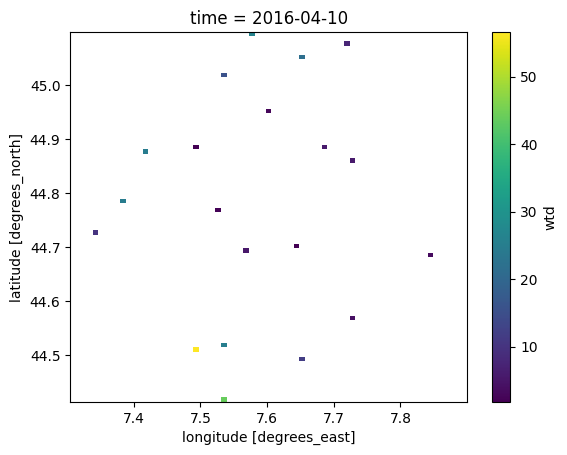

In [48]:
prova["wtd"].sel(time = np.datetime64("2016-04-10")).plot()

In [19]:
sample_date = "2020-08-22"
sample_geopd = wtd_data_geop.loc[wtd_data_geop["date"] == np.datetime64(sample_date),:]
sample_geopd

,date,wtd,geometry
279000,2020-08-22,NaN,POINT (7.64029 44.69885)
279001,2020-08-22,NaN,POINT (7.7264 44.56782)
279002,2020-08-22,38.936667,POINT (7.53722 44.41863)
279003,2020-08-22,6.170000,POINT (7.72379 44.86086)
279004,2020-08-22,3.933333,POINT (7.67314 44.963)
279005,2020-08-22,2.390000,POINT (7.4948 44.88944)
279006,2020-08-22,4.680000,POINT (7.68794 44.77265)
279007,2020-08-22,23.590000,POINT (7.53227 44.51818)
279008,2020-08-22,21.900000,POINT (7.65555 45.051)
279009,2020-08-22,24.223333,POINT (7.3085 44.82984)


In [22]:
sample_wtd_grid = make_geocube(
    vector_data=sample_geopd,
    measurements=['wtd'],
    output_crs="epsg:4326",
    resolution=(dtm_roi_upsampled.rio.transform().a, dtm_roi_upsampled.rio.transform().e),
)

In [23]:
sample_wtd_grid

<xarray.Dataset> Size: 48kB
Dimensions:      (y: 82, x: 71)
Coordinates:
  * y            (y) float64 656B 44.42 44.43 44.43 44.44 ... 45.08 45.09 45.09
  * x            (x) float64 568B 7.896 7.887 7.879 7.87 ... 7.326 7.317 7.309
    spatial_ref  int64 8B 0
Data variables:
    wtd          (y, x) float64 47kB nan nan nan nan nan ... nan nan nan nan nan

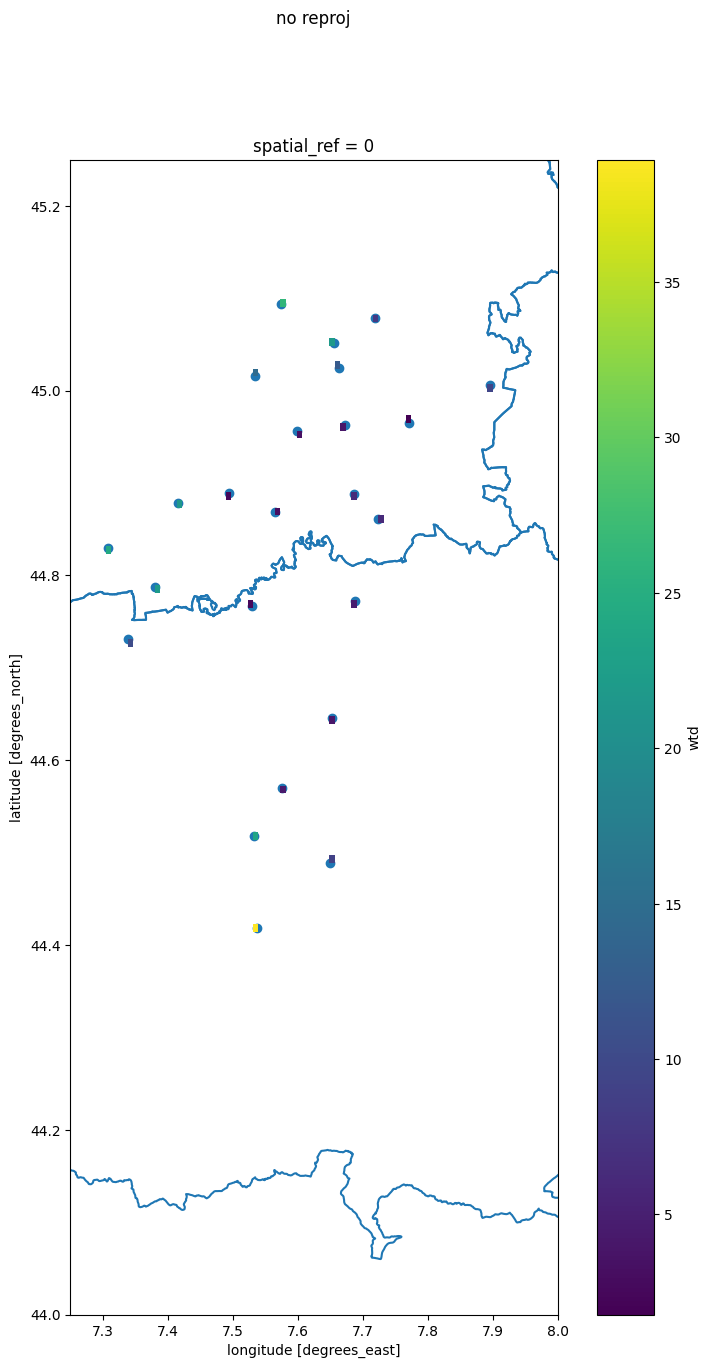

In [24]:
fig, ax = plt.subplots(figsize = (10,15))
sample_geopd.dropna().plot(ax = ax)
sample_wtd_grid["wtd"].plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))
fig.suptitle("no reproj")
plt.show()

# OLD

In [16]:
wtd_data = wtd_data.set_index(['date','lat','lon'])
wtd_data = wtd_data.drop(columns = "sensor_id")
wtd_data

wtd
date       lat       lon                
1996-01-01 44.698854 7.640289   1.700000
           44.567817 7.726400        NaN
           44.418627 7.537215        NaN
           44.860859 7.723791        NaN
           44.963005 7.673142        NaN
...                                  ...
2023-12-31 44.956561 7.598704   3.553333
           44.787024 7.735140        NaN
           45.005577 7.894828  14.500000
           44.965446 7.770635   2.056667
           45.024540 7.663686        NaN

[317037 rows x 1 columns]

In [17]:
# min_lon = str(daily_wtd_roi.index.get_level_values(0).min())
# max_lon = str(daily_wtd_roi.index.get_level_values(0).max())

# filled_date_range = pd.date_range(min_lon, max_lon, freq="D")

In [18]:
rasterizes_wtd_data = wtd_data.to_xarray()

In [19]:
rasterizes_wtd_data

<xarray.Dataset> Size: 79MB
Dimensions:  (date: 10227, lat: 31, lon: 31)
Coordinates:
  * date     (date) datetime64[ns] 82kB 1996-01-01 1996-01-02 ... 2023-12-31
  * lat      (lat) float64 248B 44.42 44.49 44.51 44.52 ... 45.05 45.08 45.09
  * lon      (lon) float64 248B 7.309 7.339 7.381 7.416 ... 7.846 7.848 7.895
Data variables:
    wtd      (date, lat, lon) float64 79MB nan nan nan nan ... nan nan nan nan

In [20]:
rasterizes_wtd_data = rasterizes_wtd_data.rio.write_crs("epsg:4326")

In [21]:
rasterizes_wtd_data = rasterizes_wtd_data.rename({"lat":"y",
                            "lon":"x"})

In [22]:
upscale_factor = 0.1
new_width = int(dtm_roi.rio.width * upscale_factor)
new_height = int(dtm_roi.rio.height * upscale_factor)

dtm_roi_upsampled = dtm_roi.rio.reproject(
    dtm_roi.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

In [23]:
dtm_roi_upsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 114, x: 168)> Size: 77kB
array([[[2899.5454 , 2800.0447 , 2652.8933 , ...,  207.18225,
          203.91689,  200.8909 ],
        [2745.5928 , 2573.3943 , 2378.1335 , ...,  201.14403,
          197.62209,  194.39249],
        [2582.547  , 2200.7563 , 2236.475  , ...,  196.59752,
          194.13895,  190.74823],
        ...,
        [1816.2076 , 2051.5916 , 2158.6135 , ...,  829.5154 ,
          808.9886 ,  741.43695],
        [1769.3004 , 1817.0792 , 1762.4233 , ...,  840.6071 ,
          823.92474,  812.00555],
        [1609.5911 , 1636.23   , 1672.0851 , ...,  833.7745 ,
          827.46497,  753.8922 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 1kB 6.63 6.639 6.647 6.655 ... 8.009 8.017 8.025
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.32 44.31
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

In [24]:
rasterizes_wtd_data_reprj = rasterizes_wtd_data.rio.reproject_match(dtm_roi_upsampled, resampling=Resampling.average)

In [25]:
rasterizes_wtd_data_reprj

<xarray.Dataset> Size: 2GB
Dimensions:      (date: 10227, x: 168, y: 114)
Coordinates:
  * date         (date) datetime64[ns] 82kB 1996-01-01 1996-01-02 ... 2023-12-31
    spatial_ref  int64 8B 0
  * x            (x) float64 1kB 6.63 6.639 6.647 6.655 ... 8.009 8.017 8.025
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.32 44.31
Data variables:
    wtd          (date, y, x) float64 2GB nan nan nan nan ... nan nan nan nan

In [26]:
piedmont_long_min, piedmont_lat_min, piedmont_long_max, piedmont_lat_max = piedmont_bounds.total_bounds

# Visualization

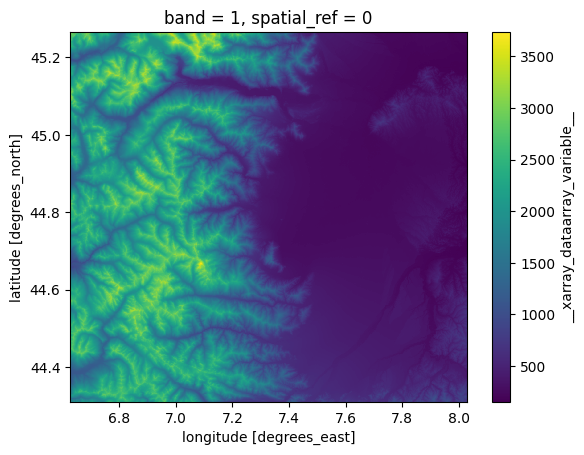

In [27]:
dtm_roi.plot()

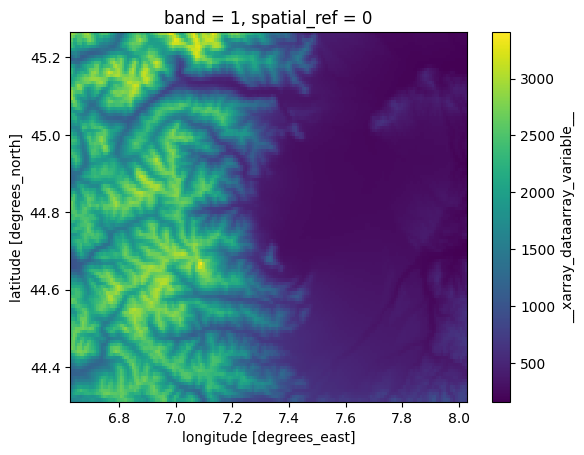

In [28]:
dtm_roi_upsampled.plot()

(44.06009314316359, 46.46443883071589)

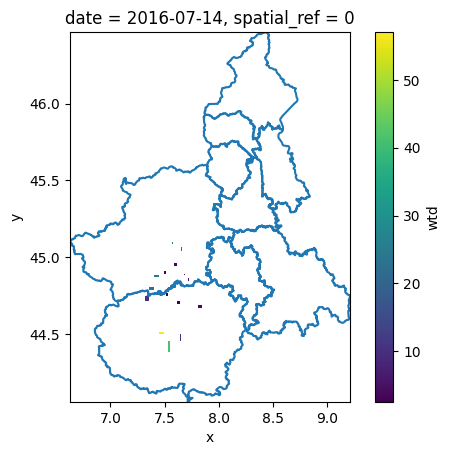

In [29]:
fig, ax = plt.subplots()
rasterizes_wtd_data["wtd"][7500].plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((piedmont_long_min, piedmont_long_max))
ax.set_ylim((piedmont_lat_min, piedmont_lat_max))

(44.0, 45.25)

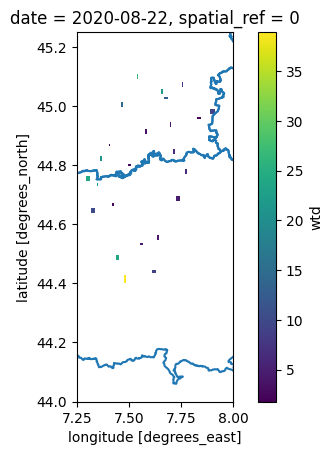

In [30]:
fig, ax = plt.subplots()
rasterizes_wtd_data_reprj["wtd"][9000].plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))



In [31]:
wtd_data

wtd
date       lat       lon                
1996-01-01 44.698854 7.640289   1.700000
           44.567817 7.726400        NaN
           44.418627 7.537215        NaN
           44.860859 7.723791        NaN
           44.963005 7.673142        NaN
...                                  ...
2023-12-31 44.956561 7.598704   3.553333
           44.787024 7.735140        NaN
           45.005577 7.894828  14.500000
           44.965446 7.770635   2.056667
           45.024540 7.663686        NaN

[317037 rows x 1 columns]

In [ ]:
wtd_data_geop = gpd.GeoDataFrame(
    wtd_data, geometry=gpd.points_from_xy(wtd_data.index.get_level_values(2), 
                                          wtd_data.index.get_level_values(1)), crs="EPSG:4326")
sample_date = "2020-08-22"
sample_geopd = wtd_data_geop.loc[pd.IndexSlice[wtd_data_geop.index.get_level_values(0) == np.datetime64(sample_date),:,:]]

In [34]:
len(sample_geopd.dropna())

24

In [35]:
(~rasterizes_wtd_data["wtd"].sel(date = np.datetime64(sample_date)).isnull()).sum()

<xarray.DataArray 'wtd' ()> Size: 8B
array(24)
Coordinates:
    date         datetime64[ns] 8B 2020-08-22
    spatial_ref  int64 8B 0

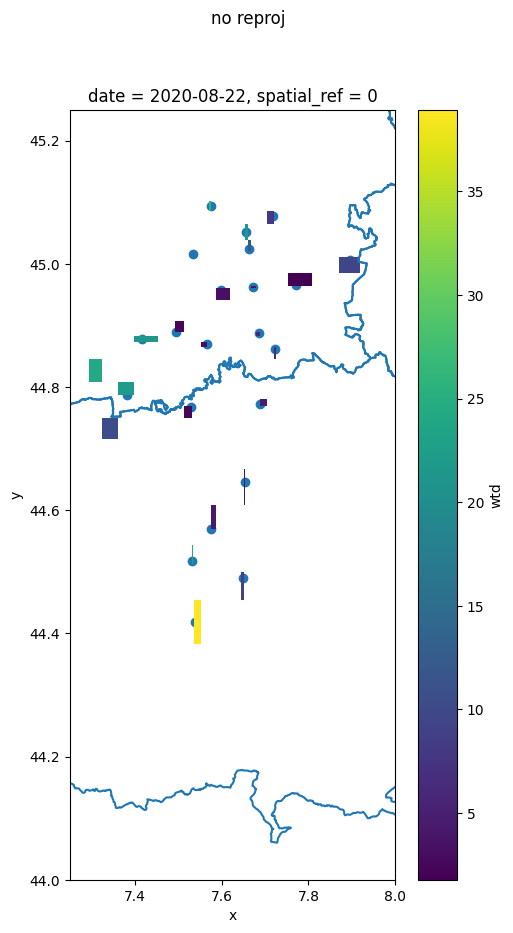

In [36]:
fig, ax = plt.subplots(figsize = (6,10))
sample_geopd.dropna().plot(ax = ax)
rasterizes_wtd_data["wtd"].sel(date = np.datetime64(sample_date)).plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))
fig.suptitle("no reproj")
plt.show()

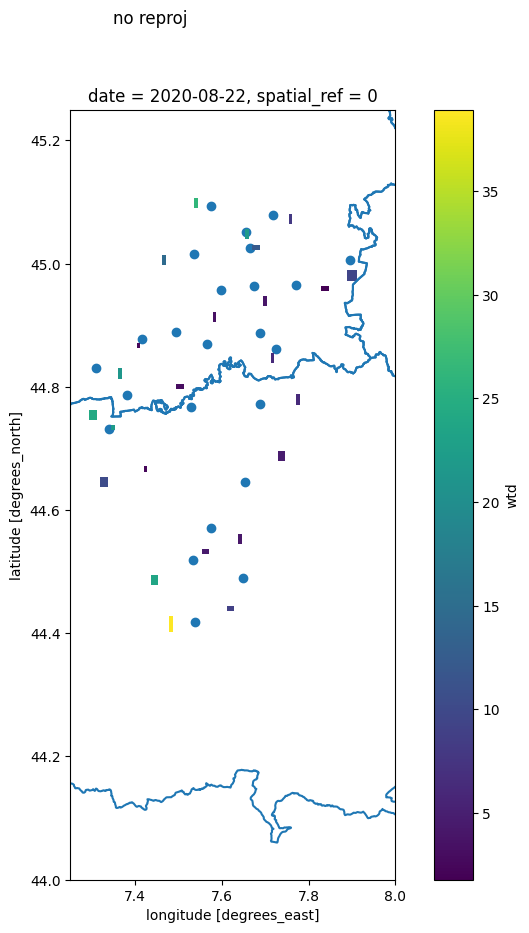

In [37]:
fig, ax = plt.subplots(figsize = (10,10))
sample_geopd.dropna().plot(ax = ax)
rasterizes_wtd_data_reprj["wtd"].sel(date = np.datetime64(sample_date)).plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))
fig.suptitle("no reproj")
plt.show()

In [38]:
bounds = dtm_roi_upsampled.rio.bounds()

In [39]:
bounds

(6.62625, 44.310416666666676, 8.029583333333333, 45.26541666666667)

In [40]:
x_coords = np.linspace(bounds[0], bounds[2], dtm_roi_upsampled.rio.width)
y_coords = np.linspace(bounds[3], bounds[1], dtm_roi_upsampled.rio.height)

# Create a new grid
target_grid = xarray.Dataset(
    {
        "lat": ("y", y_coords),
        "lon": ("x", x_coords),
    }
)

In [41]:
dtm_roi_upsampled.rio.transform()

Affine(0.008353174603174602, 0.0, 6.62625,
       0.0, -0.008377192982456125, 45.26541666666667)

In [42]:
reprojected_xarray = rasterizes_wtd_data.rio.reproject(
    dtm_roi_upsampled.rio.crs,
    shape=(dtm_roi_upsampled.rio.height, dtm_roi_upsampled.rio.width),
    # resolution=(dtm_roi_upsampled.rio.transform().a, dtm_roi_upsampled.rio.transform().e),
    transform=dtm_roi_upsampled.rio.transform()
)

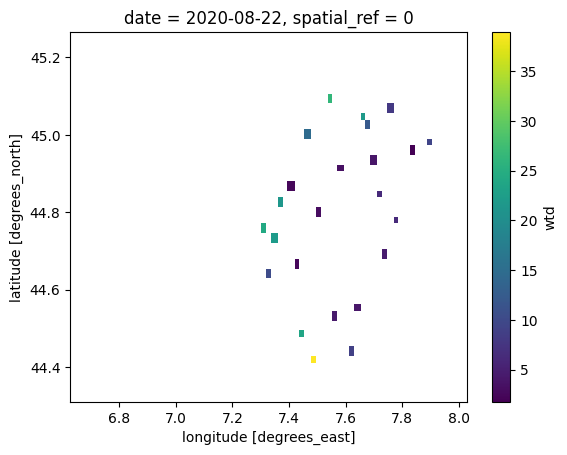

In [43]:
reprojected_xarray["wtd"].sel(date = np.datetime64(sample_date)).plot()

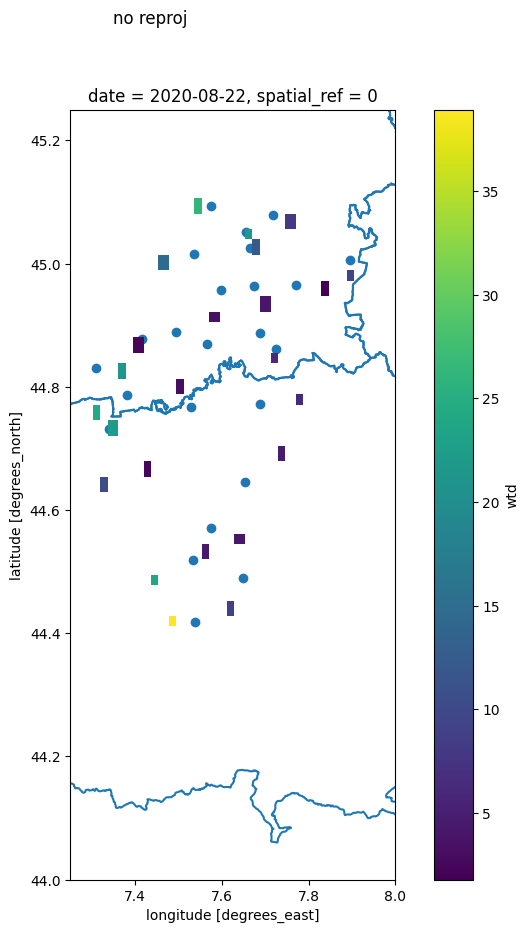

In [44]:
fig, ax = plt.subplots(figsize = (10,10))
sample_geopd.dropna().plot(ax = ax)
reprojected_xarray["wtd"].sel(date = np.datetime64(sample_date)).plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))
fig.suptitle("no reproj")
plt.show()

In [45]:
aligned_xarray = reprojected_xarray.sel(date = np.datetime64(sample_date)).interp(
    x=x_coords,
    y=y_coords,
    method="nearest"  # You can use 'linear' for bilinear interpolation
)

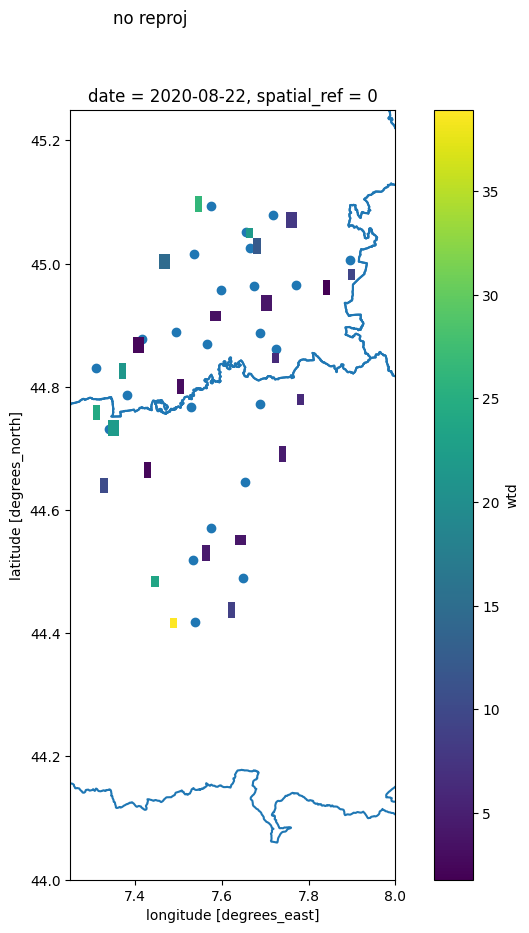

In [46]:
fig, ax = plt.subplots(figsize = (10,10))
sample_geopd.dropna().plot(ax = ax)
aligned_xarray["wtd"].plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))
fig.suptitle("no reproj")
plt.show()


In [47]:
print(dtm_roi_upsampled.rio.width)
print(dtm_roi_upsampled.rio.height)
print(dtm_roi_upsampled.rio.bounds)
print(dtm_roi_upsampled.rio.crs)

168
114
<bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x7feac4ddf790>>
EPSG:4326


In [68]:
sample_geopd

wtd                  geometry
date       lat       lon                                          
2020-08-22 44.698854 7.640289        NaN  POINT (7.64029 44.69885)
           44.567817 7.726400        NaN   POINT (7.7264 44.56782)
           44.418627 7.537215  38.936667  POINT (7.53722 44.41863)
           44.860859 7.723791   6.170000  POINT (7.72379 44.86086)
           44.963005 7.673142   3.933333    POINT (7.67314 44.963)
           44.889443 7.494797   2.390000   POINT (7.4948 44.88944)
           44.772655 7.687935   4.680000  POINT (7.68794 44.77265)
           44.518178 7.532273  23.590000  POINT (7.53227 44.51818)
           45.051000 7.655552  21.900000    POINT (7.65555 45.051)
           44.829842 7.308503  24.223333   POINT (7.3085 44.82984)
           44.731182 7.339481  10.286667  POINT (7.33948 44.73118)
           44.508433 7.489818        NaN  POINT (7.48982 44.50843)
           44.645956 7.652421   3.960000  POINT (7.65242 44.64596)
           44.925444 7.847733        NaN  POINT (7.84773 44.92544)
           44.688819 7.845734        NaN  POINT (7.84573 44.68882)
           44.570116 7.575033   4.340000  POINT (7.57503 44.57012)
           44.887933 7.686849   6.166667  POINT (7.68685 44.88793)
           44.766778 7.529275   2.380000  POINT (7.52928 44.76678)
           45.093902 7.574672  26.180000   POINT (7.57467 45.0939)
           45.078155 7.718708   7.886667  POINT (7.71871 45.07816)
           45.016302 7.534463  14.586667   POINT (7.53446 45.0163)
           44.868875 7.564895   2.996667  POINT (7.56489 44.86888)
           44.489044 7.649651   8.920000  POINT (7.64965 44.48904)
           44.689577 7.567702        NaN   POINT (7.5677 44.68958)
           44.877920 7.415599  21.403333   POINT (7.4156 44.87792)
           44.787368 7.381028  22.056667  POINT (7.38103 44.78737)
           44.956561 7.598704   3.320000   POINT (7.5987 44.95656)
           44.787024 7.735140        NaN  POINT (7.73514 44.78702)
           45.005577 7.894828   9.416667  POINT (7.89483 45.00558)
           44.965446 7.770635   1.780000  POINT (7.77064 44.96545)
           45.024540 7.663686  12.196667  POINT (7.66369 45.02454)

In [79]:
s = sample_geopd.dropna()

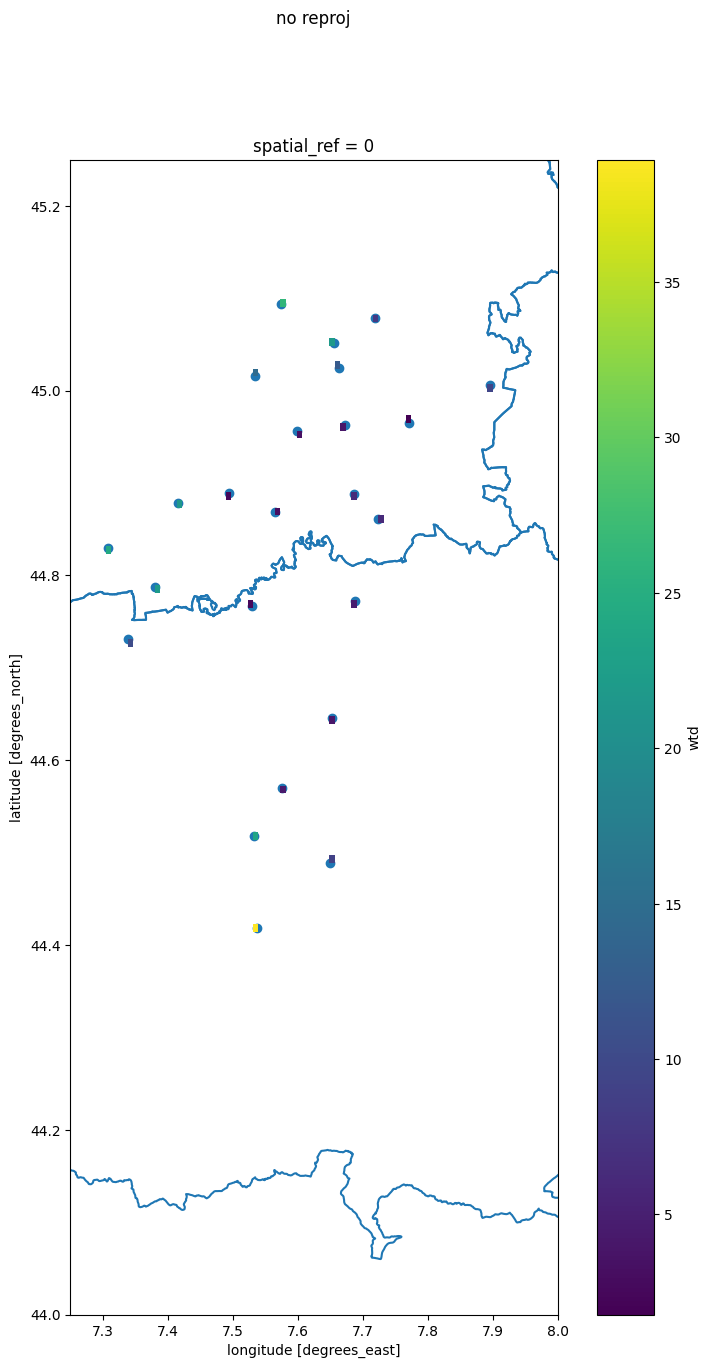

In [ ]:
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

geo_grid = make_geocube(
    vector_data=s,
    measurements=['wtd'],
    output_crs="epsg:4326",
    resolution=(dtm_roi_upsampled.rio.transform().a, dtm_roi_upsampled.rio.transform().e),
)

fig, ax = plt.subplots(figsize = (10,15))
sample_geopd.dropna().plot(ax = ax)
geo_grid["wtd"].plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))
fig.suptitle("no reproj")
plt.show()

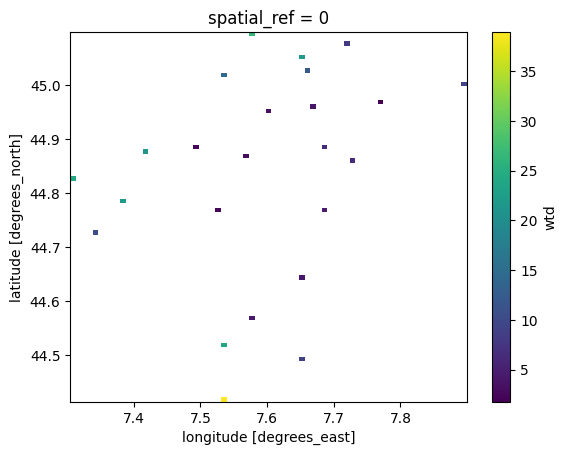

In [82]:
geo_grid["wtd"].plot()

In [83]:
geo_grid["wtd"].rio.to_raster("example.tif")

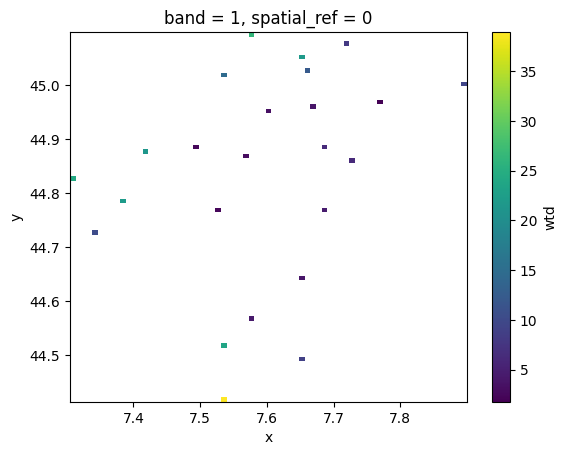

In [96]:
xds = xarray.open_dataset("example.tif", decode_coords="all")
xds["band_data"].plot()